# Explore HKUST collaborations using OpenAlex publication data

This notebook was built based on [the tutorial created by University of Washington (UW)](https://github.com/ourresearch/openalex-api-tutorials/blob/main/notebooks/institutions/uw-collaborators.ipynb). It uses [OpenAlex's API](https://docs.openalex.org/) to get all of the publications that are collaborations between a given institution (in our case, HKUST) and other institutions around the world. 

(*Text in italic* are directly taken from UW's notebook, some with slight modifications.)

*[Institutions](https://docs.openalex.org/api-entities/institutions) in OpenAlex are closely linked with the [ROR registry](https://ror.org/) of research organizations. By searching the ROR website, we can find the [ROR ID for HKUST](https://ror.org/00q4vv597).*

In [1]:
# get UST ROR ID
ust_id = "https://ror.org/00q4vv597"

## Get the data for HKUST publications

*We collect all of the works from OpenAlex which have **at least one author from HKUST** and **at least one author outside HKUST**. We'll do this in two steps: first, we'll get all of the works with HKUST authors, then we'll filter to keep only the papers with at least one other affiliation.*

*Make sure to put your email address in the `email` variable. This is how you use the [polite pool](https://docs.openalex.org/how-to-use-the-api/rate-limits-and-authentication#the-polite-pool), which will get you faster and more consistent response times when using the API.*

In [2]:
### ADD YOUR EMAIL to use the polite pool
email = "lbaster@ust.hk"

# specify endpoint
endpoint = 'works'

# build the 'filter' parameter
# set year range - latest 10 years
filters = ",".join((
    f'institutions.ror:{ust_id}',
    'from_publication_date:2002-01-01',
    # 'publication_year:2022',
))

# put the URL together
filtered_works_url = f'https://api.openalex.org/{endpoint}?filter={filters}'
if email:
    filtered_works_url += f"&mailto={email}"
print(f'complete URL with filters:\n{filtered_works_url}')

complete URL with filters:
https://api.openalex.org/works?filter=institutions.ror:https://ror.org/00q4vv597,from_publication_date:2002-01-01&mailto=lbaster@ust.hk


*We've built the URL. We are requesting a list of Works from the API, using two [filters](https://docs.openalex.org/api-entities/works/filter-works) to specify which works we want. If you like, [you can use your browser](https://docs.openalex.org/how-to-use-the-api/rate-limits-and-authentication#calling-the-api-in-your-browser) (such as Firefox or Chrome) to go to the URL we've built and view the data. (Make sure you have a browser extension which formats JSON in a nice way. Otherwise the data will look like a big mess on your screen.)*

*We're more interested in getting the data into Python. So let's get the results from the API, using the `requests` library.*

In [3]:
import requests

In [4]:
r = requests.get(filtered_works_url)
results_page = r.json()
print(f"retrieved {len(results_page['results'])} works")

retrieved 25 works


*We've retrieved 25 works, but of course that isn't the total number of works by HKUST authors. We only got the first page of results. We can see how many works there actually are by looking at the `results_page['meta']['count']` value:*

In [5]:
print(results_page['meta']['count'])

51765


In [6]:
# there are 25 results per page
results_page['meta']['count'] / 25

2070.6

### Get the full publications data

*There are 51,765 works. To get all of them, we will need to [get multiple pages of results](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/paging). Since we want more than 10,000 works, we need to use the cursor paging technique. At 25 results per page, that means we will need to make more than 10,000 API calls to get all of the data we want.*

*This may seem like a lot, but don't panic! This is well under the [free allowance of 100,000 API calls per day.](https://docs.openalex.org/how-to-use-the-api/rate-limits-and-authentication)*

It takes about 30 min to get all records.

In [7]:
cursor = '*'

select = ",".join((
    'id',
    'ids',
    'title',
    'display_name',
    'publication_year',
    'publication_date',
    'primary_location',
    'open_access',
    'authorships',
    'cited_by_count',
    'is_retracted',
    'is_paratext',
    'updated_date',
    'created_date',
))

# loop through pages
works = []
loop_index = 0
while cursor:
    
    # set cursor value and request page from OpenAlex
    url = f'{filtered_works_url}&select={select}&cursor={cursor}'
    page_with_results = requests.get(url).json()
    
    results = page_with_results['results']
    works.extend(results)

    # update cursor to meta.next_cursor
    cursor = page_with_results['meta']['next_cursor']
    loop_index += 1
    if loop_index in [5, 10, 20, 50, 100] or loop_index % 500 == 0:
        print(f'{loop_index} api requests made so far')
print(f'done. made {loop_index} api requests. collected {len(works)} works')

5 api requests made so far
10 api requests made so far
20 api requests made so far
50 api requests made so far
100 api requests made so far
500 api requests made so far
1000 api requests made so far
1500 api requests made so far
2000 api requests made so far
done. made 2072 api requests. collected 51765 works


### Save the raw data for later (optional)

*Now might be a good time to save the data we just retrieved, in case this notebook restarts and we want to come back to it without having to get all of the works from the API again. The following cell allows us to do this by saving the data using the [`.pickle`](https://docs.python.org/3/library/pickle.html) data format. (If you are loading the data in this way, then you don't need to run the above cell.)*

In [1]:
import pickle

# # uncomment these lines and run to save the results so we won't have to fetch them
# # again next time we run the notebook

# import os
# if not os.path.isdir('collaborators-data'):
#     os.mkdir('collaborators-data')
# with open('collaborators-data/hkust_works_since_2002.pickle', 'wb') as outf:
#     pickle.dump(works, outf, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# OR uncomment these lines and run to load the saved results
with open('collaborators-data/hkust_works_since_2002.pickle', 'rb') as f:
    works = pickle.load(f)

In [4]:
# works[0]

### Use Pandas to organize the data

*Each work object has a lot of information, not all of which we will use. Let's get the data into a [Pandas dataframe](https://pandas.pydata.org/), limiting the number of fields to just the ones we might be interested in.*

In [5]:
import pandas as pd
data = []
for work in works:
    for authorship in work['authorships']:
        if authorship:
            author = authorship['author']
            author_id = author['id'] if author else None
            author_name = author['display_name'] if author else None
            author_position = authorship['author_position']
            for institution in authorship['institutions']:
                if institution:
                    institution_id = institution['id']
                    institution_name = institution['display_name']
                    institution_country_code = institution['country_code']
                    data.append({
                        'work_id': work['id'],
                        'work_title': work['title'],
                        'work_display_name': work['display_name'],
                        'work_publication_year': work['publication_year'],
                        'work_publication_date': work['publication_date'],
                        'author_id': author_id,
                        'author_name': author_name,
                        'author_position': author_position,
                        'institution_id': institution_id,
                        'institution_name': institution_name,
                        'institution_country_code': institution_country_code,
                    })
df = pd.DataFrame(data)

### Filter for outside collaborations

*We are only interested in publications which have at least one authorship outside of HKUST, so let's label each row with this information.*

HKUST's OpenAlex ID is: https://openalex.org/I200769079

We get it through an API search:
https://api.openalex.org/institutions?search=hong%20kong%20university%20of%20science%20technology

In [6]:
def outside_ust_collab(institution_ids):
    # Function that takes institution IDs (grouped by works)
    # and returns True if the work has at least one non-UST affiliation
    if all(institution_ids == 'https://openalex.org/I200769079'):
        return False
    else:
        return True

# transform() will return a series the same length as the dataframe, 
# which we can store as a column in the dataframe
df['is_outside_ust_collab'] = df.groupby('work_id')['institution_id'].transform(outside_ust_collab)

*Now let's create a new dataframe with only the True rows (works that are collaborations).*

In [7]:
df_collab = df[df['is_outside_ust_collab']].drop(columns='is_outside_ust_collab')
print(f"dataframe has {len(df_collab):,} rows, with {df_collab['work_id'].nunique():,} unique publications")

dataframe has 207,095 rows, with 35,026 unique publications


*We may also want to know how many of these collaborations are with institutions **outside the HK or CN,** rather than just outside HKUST. We can use a similar technique to answer this question.*

In [23]:
def international_collab(institution_country_codes):
    # Function that takes institution country codes (grouped by works)
    # and returns True if the work has at least one non-HK/CN affiliated institution
    
    # if all(institution_country_codes == 'CN|HK'): # if we include 'HK' we will get all 35,026 works
    if all(institution_country_codes == 'CN'):
        return False
    else:
        return True
df_collab['is_international_collab'] = df_collab.groupby('work_id')['institution_country_code'].transform(international_collab)
num_international_collab = df_collab[df_collab['is_international_collab']]['work_id'].nunique()
print(f"There are {num_international_collab:,} publications with international collaboration.")

There are 21,862 publications with international collaboration.


## Get the data for Institutions

In [24]:
print(f"There are {df_collab['institution_id'].nunique():,} institutions that collaborate with HKUST, in {df_collab['institution_country_code'].nunique()} countries.")

There are 5,505 institutions that collaborate with HKUST, in 122 countries.


### Query the API for institutions data

*We've found about 5.5K institutions that collaborate with HKUST. We already know the names and the countries of these institutions; these were included in the results from the `works` endpoint of the API. There is some more information about the institutions that would be helpful to supply to the dashboard, especially the geolocation data that can be used to show the collaborations on maps. This information can be found in the [Institutions](https://docs.openalex.org/api-entities/institutions) entities.*

*To get the institutions, we will query the `/institutions` endpoint of the API. We will use the technique to get multiple entities per API request as suggested [here](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/filter-entity-lists#addition-or). This technique involves getting 50 results at once by requesting them in a filter, separated by a pipe ('`|`').*

*This will get all of the institutions in about 100 API calls, which should only take a few minutes.*

In [26]:
import requests

institution_ids = df['institution_id'].dropna().unique()

endpoint = "institutions"
size = 50
loop_index = 0
institutions = []
for list_index in range(0, len(institution_ids), size):
    subset = institution_ids[list_index:list_index+size]
    pipe_separated_ids = "|".join(subset)
    r = requests.get(f"https://api.openalex.org/institutions?filter=openalex:{pipe_separated_ids}&per-page={size}")
    results = r.json()['results']
    institutions.extend(results)
    loop_index += 1
print(f"collected {len(institutions)} institutions using {loop_index} api calls")

collected 5299 institutions using 111 api calls


*Again, let's put this data into a Pandas dataframe.*

In [27]:
data = []
for institution in institutions:
    data.append({
        'id': institution['id'],
        'ror': institution['ror'],
        'display_name': institution['display_name'],
        'country_code': institution['country_code'],
        'type': institution['type'],
        'latitude': institution['geo']['latitude'],
        'longitude': institution['geo']['longitude'],
        'city': institution['geo']['city'],
        'region': institution['geo']['region'],
        'country': institution['geo']['country'],
        # 'image_url': institution['image_url'],
        # 'image_thumbnail_url': institution['image_thumbnail_url'],
    })

df_institutions = pd.DataFrame(data)

## Save the data

*Now it's time to save the data, so it can be used for visualization. We'll save two different files:*
- *The publications data will have one row for each publication-author-affiliation triplet. Each publication will have multiple rows, because there are multiple authors per paper. An author in a given publication could have more than one row, if they have more than one affiliation.*
- *The institutions data will have one row per institution, connected to the publications data by the `institution_id` column.*

In [28]:
import os
if not os.path.isdir('collaborators-data'):
    os.mkdir('collaborators-data')
    
# Save the publications data
# Each row represents a publication-author-affiliation
#
# Compressing the data as a GZIP file will greatly reduce the file size.
# Pandas knows to use GZIP compression if the file name ends in `.gz`
outpath = 'collaborators-data/ust_collabs.csv.gz'
df_collab.to_csv(outpath, index=False)

# Save the institutions data
outpath = 'collaborators-data/ust_collabs_institutions.csv.gz'
df_institutions.to_csv(outpath, index=False)

## Reload the data

In [1]:
import pandas as pd

# Reload the publications data
collabs_path = 'collaborators-data/ust_collabs.csv.gz'
df_collab = pd.read_csv(collabs_path)

# Load the institutions data
institutions_path = 'collaborators-data/ust_collabs_institutions.csv.gz'
df_institutions = pd.read_csv(institutions_path)

## Visualize the data

*Let's have a few quick visualizations of our own. We can start with simply showing the number of international collaborations among HKUST publications over time.*

### Collaborations over time

*We'll use the python visualization library [Plotly](https://plotly.com/python/)—specifically, the [`plotly.express`](https://plotly.com/python/plotly-express/) module. It is very easy to get up and running visualizing our data, and as a bonus, the plots are interactive. (Interactive charts will not work if you're viewing this pre-rendered on github. They will only work if you are running the notebook yourself. See inline comments.)*

In [2]:
import plotly.express as px
# import plotly.io as pio

In [17]:
import country_converter as coco

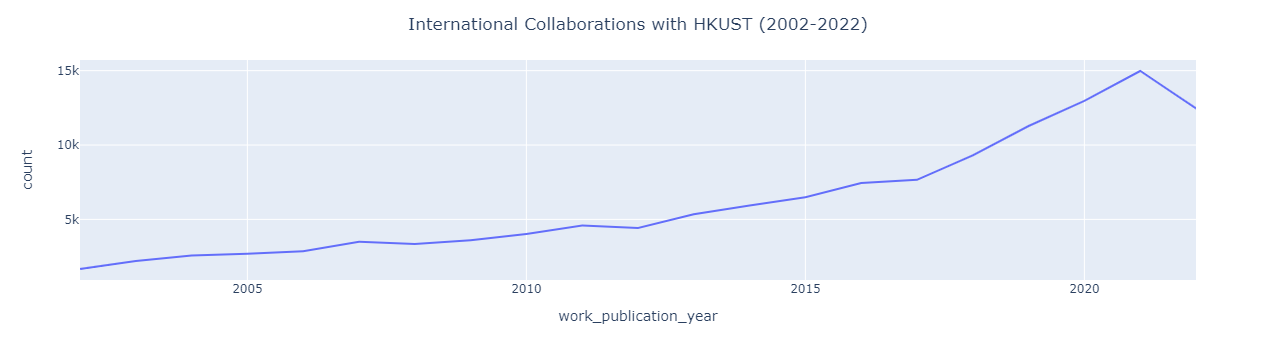

In [18]:
# Count the international collaborations by year
international_collabs_by_year = df_collab.groupby('work_publication_year')['is_international_collab'].sum().reset_index(name='count')

# Exclude the year 2023
international_collabs_by_year = international_collabs_by_year[international_collabs_by_year['work_publication_year']<2023]

fig = px.line(international_collabs_by_year, x='work_publication_year', y='count')
fig.update_layout(title_text = 'International Collaborations with HKUST (2002-2022)', 
                 title_x = 0.5)

# for an interactive plot, remove the renderer parameter, and just run `fig.show()`
# fig.show(renderer="svg")
fig.show()

In [21]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Export the images
import os

if not os.path.isdir('collaborators-data/images'):
    os.mkdir('collaborators-data/images')
    
fig.write_image('collaborators-data/images/fig1.svg')

*Next, let's plot the same data, but this time by country. We'll plot the top ten countries.*

*We'll use the [country_converter](https://github.com/IndEcol/country_converter) python library to get more readable names for the countries.*

In [2]:
pip install country_converter

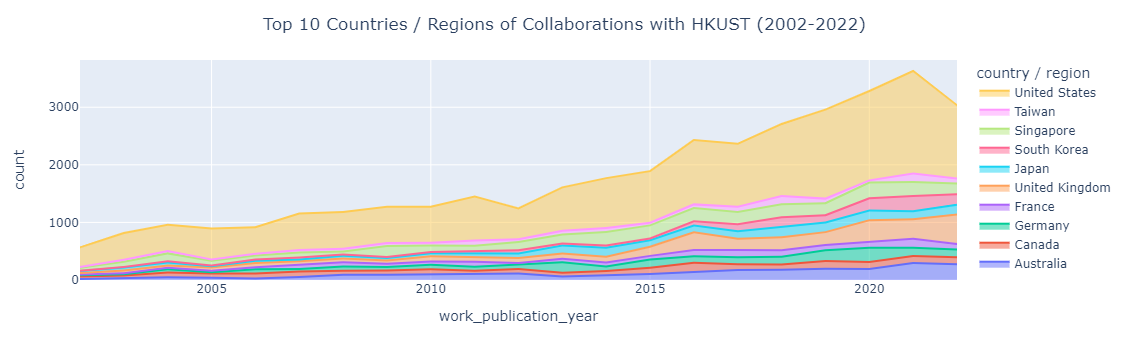

In [26]:
# Get the counts by year by country
country_by_year = df_collab.groupby(['work_publication_year', 'institution_country_code']).size().reset_index(name='count')

# Get the names of the countries from the country codes
cc = coco.CountryConverter()
country_by_year['country'] = cc.pandas_convert(country_by_year['institution_country_code'], to='name_short')

# Filter out collaborations with other CN institutions
country_by_year = country_by_year[country_by_year['institution_country_code']!='CN']

# Exclude the year 2023
country_by_year = country_by_year[country_by_year['work_publication_year']<2023]

# Get the top ten countries
top_countries = country_by_year.groupby('institution_country_code')['count'].sum().sort_values(ascending=False).head(10).index
country_by_year_subset = country_by_year[country_by_year['institution_country_code'].isin(top_countries)]

# Plot the data
fig = px.area(country_by_year_subset, x='work_publication_year', y='count', color='country')
fig.update_layout(title_text = 'Top 10 Countries / Regions of Collaborations with HKUST (2002-2022)', 
                 title_x = 0.5, 
                 legend_traceorder = "reversed", 
                 legend_title_text = 'country / region')

# for an interactive plot, remove the renderer parameter, and just run `fig.show()`
# fig.show(renderer='svg')
fig.show()

In [27]:
fig.write_image('collaborators-data/images/fig2.svg')

### Chloropleth map

*Finally, let's make a [chloropleth map](https://en.wikipedia.org/wiki/Choropleth_map), which uses color to show the number of collaborations in countries around the world.*

In [22]:
country_counts = df_collab['institution_country_code'].value_counts()
country_counts = country_counts[country_counts.index!='CN']

In [23]:
country_counts = country_counts.rename_axis('country_code').reset_index(name='num_collaborations')

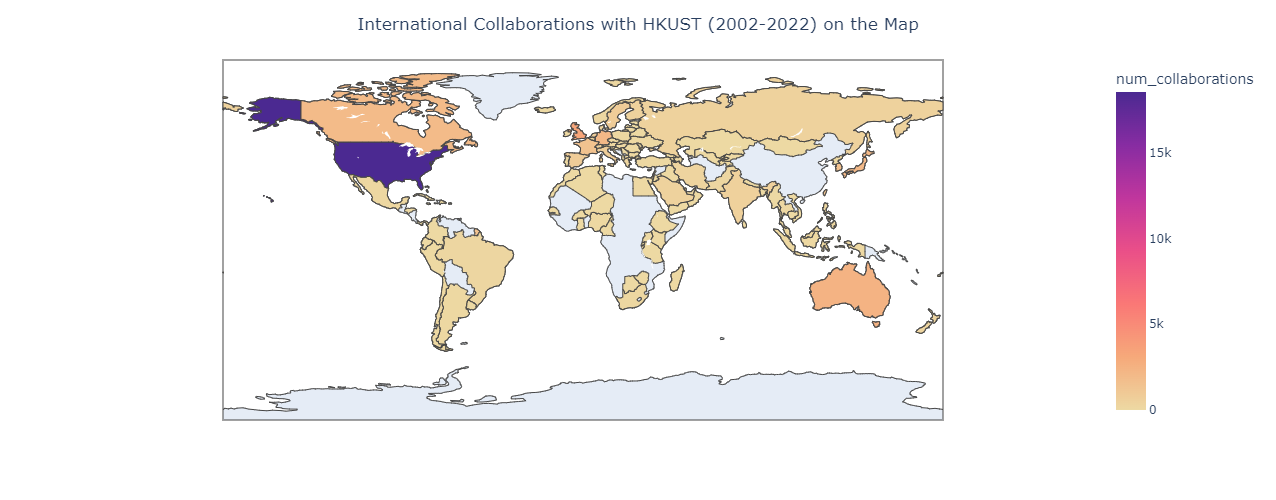

In [24]:
# Get the names of the countries from the country codes
cc = coco.CountryConverter()
country_counts['country'] = cc.pandas_convert(country_counts['country_code'], to='name_short')

# The Plotly chloropleth method needs the ISO3 (3-letter) country code
country_counts['country_code_ISO3'] = cc.pandas_convert(country_counts['country_code'], to='ISO3')

# Make the map
fig = px.choropleth(country_counts, locations='country_code_ISO3', locationmode='ISO-3', 
                    color='num_collaborations', color_continuous_scale='agsunset_r', 
                    hover_name='country')

# for an interactive plot, remove the renderer parameter, and just run `fig.show()`
# fig.show(renderer='png')

fig.update_layout(
    autosize=True,
    width=1000, height=500, 
    title_text = 'International Collaborations with HKUST (2002-2022) on the Map', 
    title_x = 0.5)

fig.show()

In [25]:
fig.write_image('collaborators-data/images/fig3.svg')